In [1]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(1)  
T = 100  # length of time series
phi_true = 0.9                 # true AR(1) coefficient
alpha_true = 1.5               # true measurement coefficient
sigma2_true = 0.1              # true process noise variance
tau2_true = 0.2                # true measurement noise variance

# Initialize arrays
x_true = np.zeros(T)
y_obs  = np.zeros(T)

# Initial state x_0 (assume start at 0 for simplicity, or draw from steady-state distribution)
x_true[0] = np.random.normal(0, np.sqrt(sigma2_true/(1-phi_true**2)))
y_obs[0]  = alpha_true * x_true[0] + np.random.normal(0, np.sqrt(tau2_true))

# Simulate forward
for t in range(1, T):
    x_true[t] = phi_true * x_true[t-1] + np.random.normal(0, np.sqrt(sigma2_true))
    y_obs[t]  = alpha_true * x_true[t] + np.random.normal(0, np.sqrt(tau2_true))

# Display first few data points
print("First 5 true states:", x_true[:5])
print("First 5 observations:", y_obs[:5])


First 5 true states: [1.17842398 0.89355901 1.07786903 1.52184005 1.47054507]
First 5 observations: [1.49405019 0.86049236 0.58752415 1.94233801 2.09429578]


In [2]:
def particle_filter(y_observations, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2, N=1000):
    """
    Perform Particle Filter state estimation.
    Returns an array of estimated states (weighted particle mean) for each time step.
    """
    T = len(y_observations)
    # Initialize particles from prior (assume prior ~ N(0, steady-state variance))
    if phi**2 < 1:
        init_var = sigma2 / (1 - phi**2)
    else:
        init_var = sigma2 * 10  # arbitrary large variance if non-stationary
    particles = np.random.normal(0, np.sqrt(init_var), size=N)
    weights = np.ones(N) / N  # start with equal weights

    state_estimates = np.zeros(T)
    # Update weights with first observation y0
    diff0 = y_observations[0] - alpha * particles       # innovation for each particle
    likelihoods = (1/np.sqrt(2*np.pi*tau2)) * np.exp(-0.5 * (diff0**2) / tau2)
    weights *= likelihoods
    weights /= np.sum(weights)                          # normalize weights
    state_estimates[0] = np.sum(weights * particles)    # weighted mean estimate

    # Resample particles based on weights
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    particles = particles[indices]
    weights.fill(1.0/N)  # reset weights to uniform after resampling

    # Iterate through time steps 1 to T-1
    for t in range(1, T):
        # Prediction: propagate each particle according to state model
        particles = phi * particles + np.random.normal(0, np.sqrt(sigma2), size=N)
        # Update: weight particles by likelihood of observation y[t]
        diff = y_observations[t] - alpha * particles
        likelihoods = (1/np.sqrt(2*np.pi*tau2)) * np.exp(-0.5 * (diff**2) / tau2)
        weights *= likelihoods
        weights /= np.sum(weights)                      # normalize
        state_estimates[t] = np.sum(weights * particles)
        # Resample
        indices = np.random.choice(np.arange(N), size=N, p=weights)
        particles = particles[indices]
        weights.fill(1.0/N)
    return state_estimates

# Run particle filter on the simulated data
x_pf_est = particle_filter(y_obs, phi=phi_true, alpha=alpha_true, sigma2=sigma2_true, tau2=tau2_true, N=1000)


In [3]:
# Compute PF estimation error
pf_errors = x_pf_est - x_true
print("Particle Filter RMSE:", np.sqrt(np.mean(pf_errors**2)))


Particle Filter RMSE: 0.2380891664406956


In [4]:
def kalman_filter(y_observations, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2):
    """
    Kalman Filter for state estimation in a linear Gaussian model.
    Returns arrays of filtered state means and variances.
    """
    T = len(y_observations)
    x_est = np.zeros(T)
    P_est = np.zeros(T)
    # Initialize prior for x_0
    x_est[0] = 0.0
    P_est[0] = sigma2/(1-phi**2) if phi**2 < 1 else sigma2 * 10  # large prior var if not stationary
    # Update with first observation y0
    K0 = P_est[0] * alpha / (alpha**2 * P_est[0] + tau2)
    x_est[0] = x_est[0] + K0 * (y_observations[0] - alpha * x_est[0])
    P_est[0] = (1 - K0 * alpha) * P_est[0]
    # Iterate for t=1...T-1
    for t in range(1, T):
        # Predict
        x_pred = phi * x_est[t-1]
        P_pred = phi**2 * P_est[t-1] + sigma2
        # Update with y[t]
        Kt = P_pred * alpha / (alpha**2 * P_pred + tau2)
        x_est[t] = x_pred + Kt * (y_observations[t] - alpha * x_pred)
        P_est[t] = (1 - Kt * alpha) * P_pred
    return x_est, P_est

# Run Kalman filter on the data
x_kf_est, P_kf_est = kalman_filter(y_obs, phi=phi_true, alpha=alpha_true, sigma2=sigma2_true, tau2=tau2_true)
print("Kalman Filter RMSE:", np.sqrt(np.mean((x_kf_est - x_true)**2)))


Kalman Filter RMSE: 0.23843547452090239


In [5]:
import math
from math import log
from scipy.optimize import minimize

# Define a function to compute negative log-likelihood for given parameters
def neg_log_likelihood(params, observations):
    phi, alpha, log_sigma2, log_tau2 = params
    sigma2 = math.exp(log_sigma2)
    tau2   = math.exp(log_tau2)
    # Run Kalman filter to compute log-likelihood
    T = len(observations)
    # initialize
    x_mean = 0.0
    P_var = sigma2/(1-phi**2) if phi**2 < 1 else sigma2*100  # large prior var if needed
    logL = 0.0
    for t in range(T):
        # Prediction (for t=0, prediction is prior)
        # Compute innovation and its variance
        S = alpha**2 * P_var + tau2
        nu = observations[t] - alpha * x_mean
        # Update log-likelihood
        logL += -0.5*(math.log(2*math.pi*S) + (nu**2)/S)
        # Kalman update
        K = (P_var * alpha) / S
        x_mean = x_mean + K * nu
        P_var = (1 - K*alpha) * P_var
        # Predict next (except at last step, not used further)
        if t < T-1:
            x_mean = phi * x_mean
            P_var = phi**2 * P_var + sigma2
    return -logL  # return negative log-likelihood for minimization

# Initial guess for parameters
initial_guess = [0.5, 1.0, log(0.1), log(0.2)]
result = minimize(neg_log_likelihood, initial_guess, args=(y_obs,), method='Nelder-Mead')
phi_est, alpha_est, log_sigma2_est, log_tau2_est = result.x
sigma2_est = math.exp(log_sigma2_est)
tau2_est   = math.exp(log_tau2_est)

print("Estimated phi =", round(phi_est, 3))
print("Estimated alpha =", round(alpha_est, 3))
print("Estimated sigma^2 =", round(sigma2_est, 3))
print("Estimated tau^2 =", round(tau2_est, 3))


Estimated phi = 0.98
Estimated alpha = 0.732
Estimated sigma^2 = 0.216
Estimated tau^2 = 0.163


In [6]:
# State estimation using Kalman smoother with estimated parameters
x_kf_est_MLE, P_kf_est_MLE = kalman_filter(y_obs, phi=phi_est, alpha=alpha_est, sigma2=sigma2_est, tau2=tau2_est)
# (We reuse the kalman_filter function; it returns the filtered estimates.)
# Now perform Rauch-Tung-Striebel smoothing on the filtered results:
def kalman_smoother(x_filt, P_filt, phi, alpha, sigma2, tau2):
    T = len(x_filt)
    x_smooth = np.copy(x_filt)
    # Backward smoothing
    for t in range(T-2, -1, -1):
        # Compute smoothing gain
        P_pred = phi**2 * P_filt[t] + sigma2    # prior var at t+1
        G = P_filt[t] * phi / P_pred
        # Smooth the state estimate
        x_smooth[t] += G * (x_smooth[t+1] - phi * x_filt[t])
    return x_smooth

x_mle_smooth = kalman_smoother(x_kf_est_MLE, P_kf_est_MLE, phi=phi_est, alpha=alpha_est, sigma2=sigma2_est, tau2=tau2_est)
print("MLE-based method RMSE:", np.sqrt(np.mean((x_mle_smooth - x_true)**2)))


MLE-based method RMSE: 0.8551714245566057


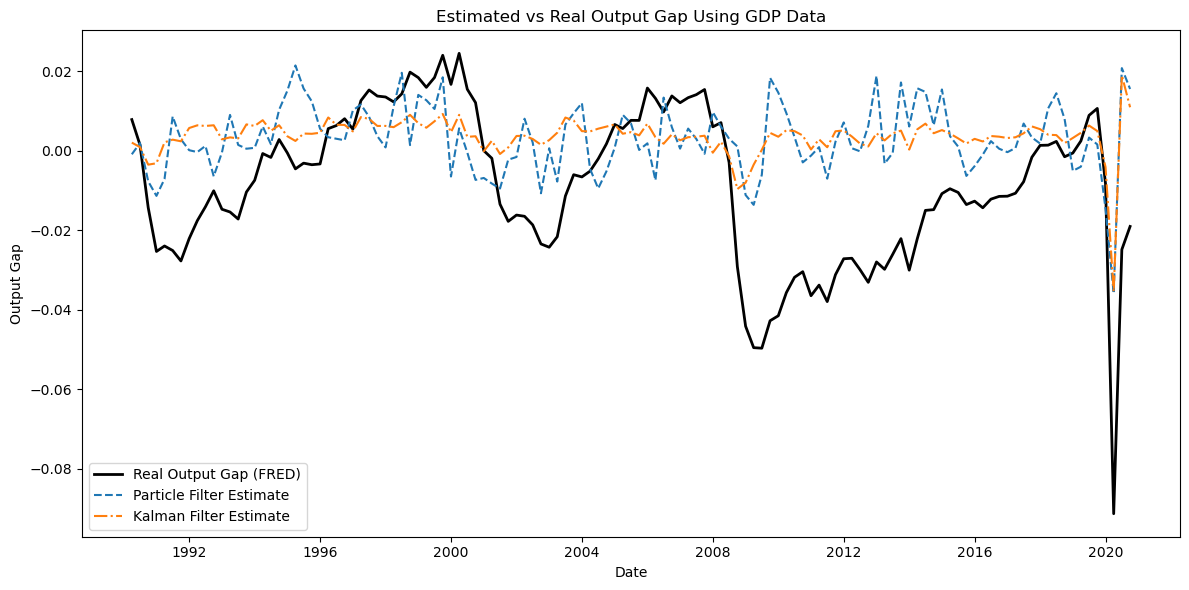

In [14]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

# Define the date range
start = datetime(1990, 1, 1)
end   = datetime(2020, 12, 31)

# Download Real GDP (GDPC1) and Potential GDP (GDPPOT) series
gdpc1  = web.DataReader('GDPC1', 'fred', start, end)
gdppot = web.DataReader('GDPPOT', 'fred', start, end)

# Merge and compute the real output gap (as percentage deviation)
df = pd.concat([gdpc1.rename(columns={'GDPC1':'RealGDP'}),
                gdppot.rename(columns={'GDPPOT':'PotentialGDP'})], axis=1).dropna()
df['OutputGap'] = (df['RealGDP'] - df['PotentialGDP']) / df['PotentialGDP']

# Compute GDP growth (log differences)
df['GDP_Growth'] = np.log(df['RealGDP']).diff()
df = df.dropna()

y_real      = df['GDP_Growth'].values
nx          = len(y_real)
x_true_real = df['OutputGap'].values

# Etimate Latent Output Gap using Particle Filter and Kalman Filter
x_pf_real = particle_filter(y_real,
                              phi=phi_true,
                              alpha=alpha_true,
                              sigma2=sigma2_true,
                              tau2=tau2_true,
                              N=1000)
x_kf_real, _ = kalman_filter(y_real,
                              phi=phi_true,
                              alpha=alpha_true,
                              sigma2=sigma2_true,
                              tau2=tau2_true)
# ## Plot Estimated vs Real Output Gap
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, x_true_real, label='Real Output Gap (FRED)', color='black', linewidth=2)
plt.plot(df.index, x_pf_real,    label='Particle Filter Estimate', linestyle='--')
plt.plot(df.index, x_kf_real,    label='Kalman Filter Estimate', linestyle='-.')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Output Gap')
plt.title('Estimated vs Real Output Gap Using GDP Data')
plt.tight_layout()
plt.show()


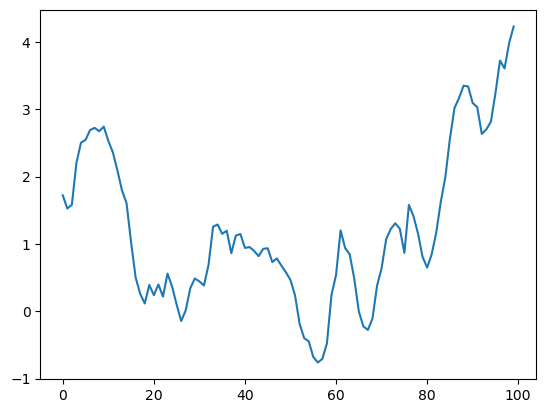

In [10]:
plt.plot(x_mle_smooth)

In [11]:
x_mle_smooth

array([ 1.72089890e+00,  1.52477500e+00,  1.58216213e+00,  2.20430144e+00,
        2.50292681e+00,  2.54405843e+00,  2.69028246e+00,  2.72262194e+00,
        2.67252246e+00,  2.74034325e+00,  2.53042368e+00,  2.35873073e+00,
        2.09097785e+00,  1.79343801e+00,  1.60424448e+00,  1.02450633e+00,
        5.00135371e-01,  2.57927313e-01,  1.14614230e-01,  3.90268388e-01,
        2.38270279e-01,  3.96819769e-01,  2.16222841e-01,  5.59093057e-01,
        3.66105619e-01,  9.78098897e-02, -1.45555267e-01,  1.41760486e-02,
        3.41549491e-01,  4.86460749e-01,  4.42094522e-01,  3.82441041e-01,
        6.87408415e-01,  1.25486419e+00,  1.28711225e+00,  1.14899846e+00,
        1.19511047e+00,  8.60810824e-01,  1.12270348e+00,  1.14652627e+00,
        9.39321288e-01,  9.53135416e-01,  8.95401168e-01,  8.18021073e-01,
        9.26573591e-01,  9.34232138e-01,  7.29163204e-01,  7.83570634e-01,
        6.77011760e-01,  5.77814075e-01,  4.61919312e-01,  2.35012684e-01,
       -1.87039958e-01, -